In [ ]:
import multiprocessing as mp

try:
    mp.set_start_method('spawn')
except RuntimeError:
    pass  # Ignore the error if the context has already been set

import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import math
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# Load the dataset
url = 'https://cnn-caroline.s3.eu-west-1.amazonaws.com/icml_face_data.csv'
df = pd.read_csv(url)


In [ ]:
# Check for any missing values in the dataset
print(df.isnull().sum())


emotion    0
 Usage     0
 pixels    0
dtype: int64


In [ ]:
# print number of ros and colums

print ("Rows", len(df))
print ("Columns", len(df.columns))

Rows 35887
Columns 3


In [ ]:
#Strip out space before pixels
df.columns = df.columns.str.strip()

In [ ]:
#Check foro unique values
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
#describe the dataset
df.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


##Visualize some images

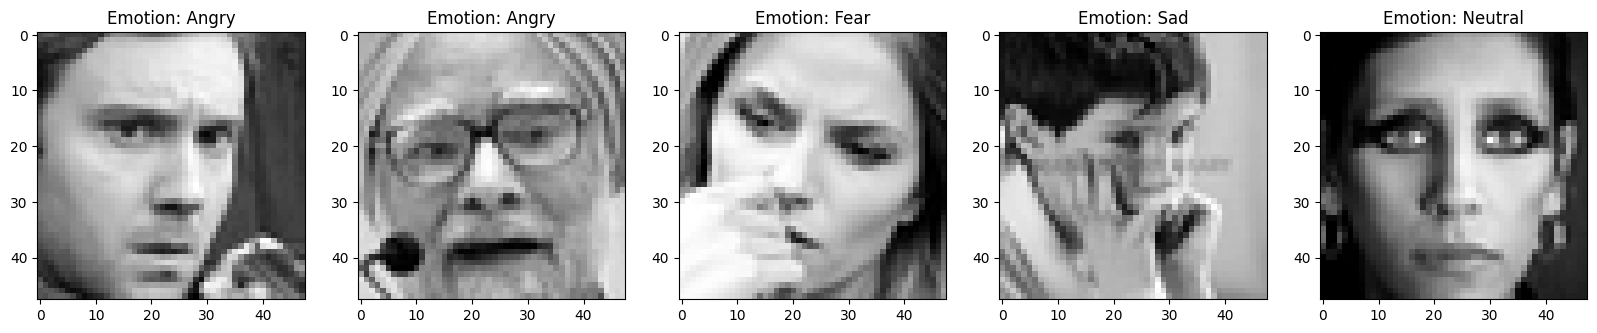

In [ ]:
#Load some imsages and inspect. They are in greyscale format!

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

for i, ax in enumerate(axes):
    # Convert the pixel string to an image array inline
    pixel_values = df.loc[i, 'pixels'].split()
    image_array = np.array(pixel_values, dtype=np.uint8).reshape(48, 48)

    # Fetch the corresponding emotion label from the list
    emotion = emotion_labels[df.loc[i, "emotion"]]

    ax.imshow(image_array, cmap='gray')
    ax.set_title(f'Emotion: {emotion}')

plt.show()


#Analyse the distribution of classes (emotions) in the dataset.



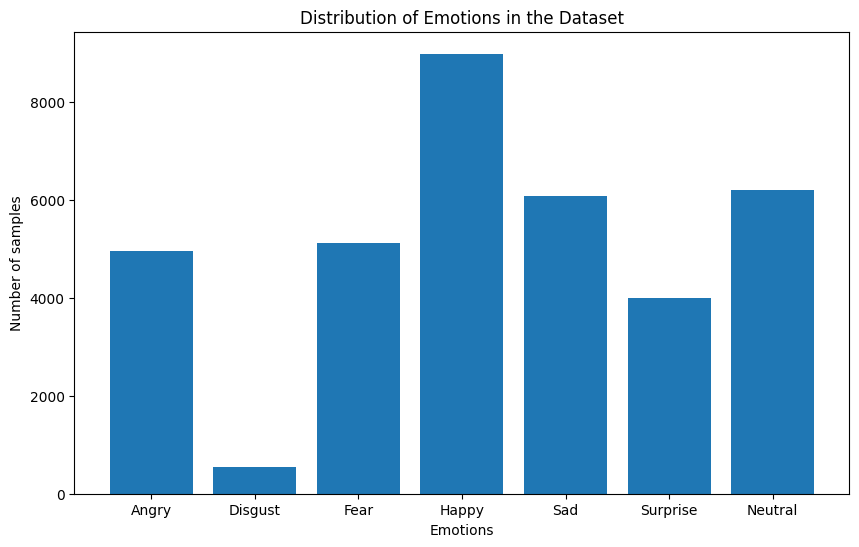

In [ ]:
# Analyze the distribution of classes
emotion_counts = df['emotion'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(emotion_labels, emotion_counts)
plt.xlabel('Emotions')
plt.ylabel('Number of samples')
plt.title('Distribution of Emotions in the Dataset')
plt.show()

In [ ]:
# Map the numeric labels to names
df['emotion_name'] = df['emotion'].apply(lambda x: emotion_labels[x])

# Count the occurrences of each emotion name
emotion_counts = df['emotion_name'].value_counts()

# Print the counts for each emotion
print(emotion_counts)

emotion_name
Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: count, dtype: int64


**Converting pixes values to int**

In [ ]:
df['pixels']=[[int(y) for y in x.split()] for x in df['pixels']]

In [ ]:
#Getting the quantity. Quite a lot of training data.
print(len(df[df['Usage']=='Training']))
print(len(df[df['Usage']=='PublicTest']))
print(len(df[df['Usage']=='PrivateTest']))

28709
3589
3589


In [ ]:
df.head()

,emotion,Usage,pixels,emotion_name
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Angry
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Angry
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",Fear
3,4,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",Sad
4,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",Neutral


#Split the training dataset into training and validation

In [ ]:
df_train=df[df['Usage']=='Training']
df_valid=df[df['Usage']=='PrivateTest']
df_test=df[df['Usage']=='PublicTest']

##Transform the augmentations

In [ ]:
"""
    Used to load image data and emotion labels.

    Attributes:
        transforms: A transform that takes in a image
            and returns a transformed version.
        target_transforms - A ransform specifically for
            with 'Sad', 'Angry' emotions.
        dff - Dataframe of image data and labels.
    """
class Dataset(Dataset):
    def __init__(self, dff, transforms=None, target_transforms=None):
        self.transforms = transforms  # General transforms for all images
        self.target_transforms = target_transforms  # Specific transforms for target emotions
        self.dff = dff

    def __len__(self):
        return len(self.dff)

    def __getitem__(self, index):
        X = self.dff.iloc[index]['pixels']
        X = np.array(X, dtype=np.uint8).reshape(48, 48)
        X_pil = Image.fromarray(X, mode='L')  # Convert to PIL image in grayscale

        # Target Sad or angry emotions only
        if self.dff.iloc[index]['emotion'] in [4, 0] and self.target_transforms:
            X_pil = self.target_transforms(X_pil)
        elif self.transforms:
            X_pil = self.transforms(X_pil)

        X = np.array(X_pil)  # Convert back to numpy array
        y = self.dff.iloc[index]['emotion']
        return X, y



Data loader parameters

In [ ]:
params = {'batch_size': 8,'shuffle': True,'num_workers': 0}

##Define augmentation

In [ ]:
#Implement various data augmentation techniques, such as random rotation, horizontal flip, width and height shift, and zoom.
class AlbumentationWrapper(object):
    """
    Applies image transformations using Albumentations

    Attributes:
        transforms: A transformation or multiple transformations
    """
    def __init__(self, transforms=None):
        self.transforms = transforms

    def __call__(self, img):
        # Apply the transforms and return the image
        img = np.array(img)
        if self.transforms:
            augmented = self.transforms(image=img)
            img = augmented['image']
        return img


#Augmentation 3 - 40 per cent training and 17 per cent test accuracy.
#train_transforms = AlbumentationWrapper(A.Compose([
#   A.HorizontalFlip(p=0.5),
#   A.Rotate(limit=15, p=0.5),
#   A.Normalize(mean=[0.5], std=[0.5 * 255])
#   ToTensorV2(),
#]))

#Augmentation 2 - 36 per cent training and 18 per cent test accuracy achieved
# train_transforms = AlbumentationWrapper(A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=20, p=0.5, border_mode=0), A.Normalize(mean=[0.5], std=[0.5]),
#     ToTensorV2(),
# ]))
#Augmentation 1 - 25 per cent training and test accuracy achieved
#train_transforms = AlbumentationWrapper(A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.1, rotate_limit=20, p=0.5, border_mode=0),
#     A.RandomResizedCrop(height=48, width=48, scale=(0.8, 1.0), p=0.5),
#     A.Normalize(mean=[0.5], std=[0.5]),
#     ToTensorV2(),
# ]))
#Augmentation 4 - 42 per cent training accuracy and 44 per cent test
#train_transforms = AlbumentationWrapper(A.Compose([
#     A.HorizontalFlip(),
#     A.Cutout(2,2,2,0.5),
#     A.GaussNoise(),
#     A.Normalize(mean=[0.5], std=[0.5 * 255]),
#     ToTensorV2(),
#  ]))

#Targeted Transform - this one is to target sad and angry emotions
target_transforms = AlbumentationWrapper(A.Compose([
    A.HorizontalFlip(),
    A.Cutout(2,2,2,0.5),
    A.GaussNoise(),
    A.Normalize(mean=[0.5], std=[0.5 * 255]),
    ToTensorV2(),
 ]))

# Create Albumentation transforms for test only
basic_transforms = AlbumentationWrapper(A.Compose([
    A.Resize(48, 48),
    A.Normalize(mean=[0.5], std=[0.5 * 255]),
    ToTensorV2(),
]))



/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning:

Cutout has been deprecated. Please use CoarseDropout



**Loading datasets**

In [ ]:

# Setup datasets with corresponding transformations
# Setup datasets with corresponding transformations
training_set = Dataset(df_train, basic_transforms, target_transforms)  # Training data with specific augmentations for sad and angry
training_generator = DataLoader(training_set, **params)

#training_set = Dataset(df_train, train_transforms)  # Training data
#training_generator = DataLoader(training_set, **params)

validation_set = Dataset(df_valid, basic_transforms)  # Validation data without augmentations
validation_generator = DataLoader(validation_set, **params)

test_set = Dataset(df_test, basic_transforms)  # Test data without augmentations
test_generator = DataLoader(test_set, **params)


##Try out with different augmentation strategies and their combinations to find the best approach.



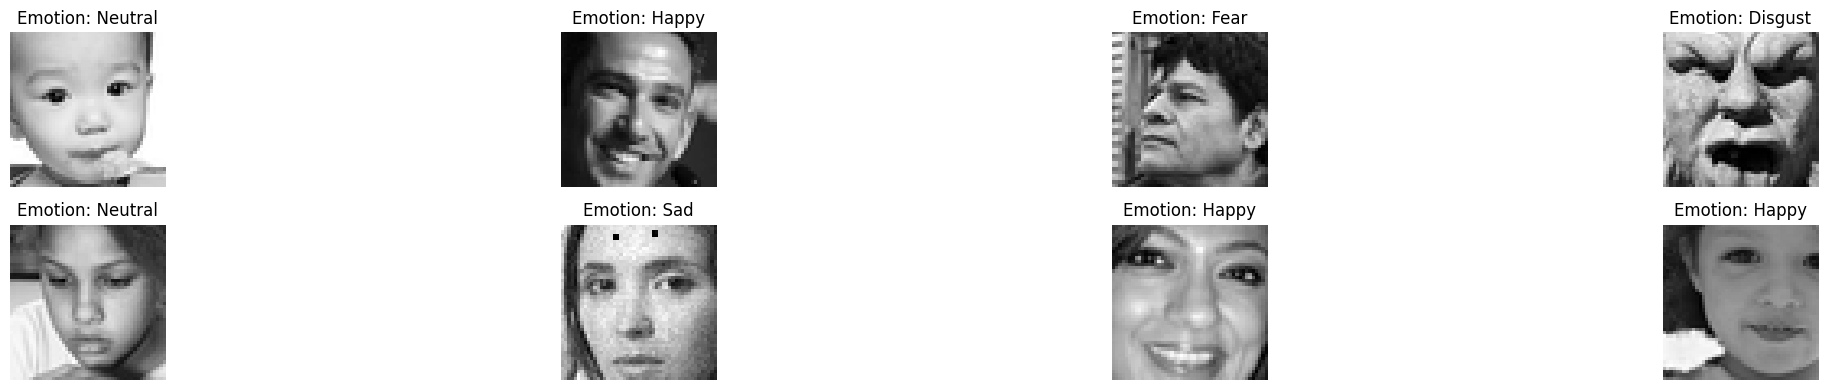

In [ ]:

# Function to denormalize and show image for visualization
def imshow(img):
    """
    Display an image by converting it to an numpy array and displaying it in greyscale.

    Parameters:
        img: A tensor representing the image.

    This function was created so that the augmentation techniques could be reviewed.
    """
    img = img.squeeze()  # Remove channel dimension if it's 1 (or batch dimension if showing a single image)
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(npimg, cmap='gray')  # Display it in grayscale

dataiter = iter(training_generator)
images, labels = next(dataiter)  # Get a batch of images

# Visualize some augmented images
fig = plt.figure(figsize=(25, 4))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
    imshow(images[idx].squeeze())  # Remove batch dimension to show a single image
    # Retrieve the label name using the label index
    label_name = emotion_labels[labels[idx].item()]
    ax.set_title(f'Emotion: {label_name}')
    ax.axis('off')  # Hide the axis details

plt.tight_layout()  # Adjust the layout
plt.show()


**Function for getting Learning rate at runtime**

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#Training Code

In [ ]:
def train(model, train_loader, optimizer, scheduler, criterion):
    """
    Trains a model for one epoch.

    Parameters:
        model: The model to be trained.
        train_loader: The DataLoader
        optimizer: The optimizer such as SGD
        scheduler: The scheduler such as the OneCycleLR
        criterion: Such as CrossEntropyLoss

    Returns:
        The training loss and the training accuracy.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(data)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        scheduler.step()  # Correct place for OneCycleLR after optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    print(f'Train Loss: {train_loss:.6f}, Train Acc: {train_accuracy:.2f}%')

    return train_loss, train_accuracy  # Return training loss and accuracy


#Test Code

In [ ]:
def test(model, test_loader, criterion):
    """
    Tests a model.

    Parameters:
        model: The model to be trained.
        test_loader: The DataLoader
        criterion: Such as CrossEntropyLoss

    Returns:
        The test loss and the test accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    print(f'Test Loss: {test_loss:.6f}, Test Acc: {test_accuracy:.2f}%')


##Validation Code

In [ ]:
def validate(model, loader, criterion):
    """
    Gets the modes performance on the validation set

    Parameters:
        model: The model to be trained.
        validation loader: The validation_generator dataloader
        criterion: Such as CrossEntropyLoss

    Returns:
        The average validation loss and accuracy

    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    average_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return average_loss, accuracy


##Design a CNN architecture for facial emotion recognition.



In [ ]:

class Net(nn.Module):
    """
    A CNN model with mulitple convolutional layers, residual blocks, and a global average pooling layer.


    Attributes:
        bn1: Batch normalization layers are inserted after convolutional layers to speed up training.
        dropout: Dropout regularization is applied to prevent overfitting by randomly ignoring certain nodes in a layer during training
        resblock: Residual blocks are used to allow memory (or information) to flow from initial to last layers.
        dilated_conv: Dilated convolutions are employed to enable the network to have a larger receptive field without increasing the number of parameters
        gap: Global average pooling layeris designed to replace flatten layer and fully connected layers
        The Kaiming or He-Normal distribution is used for weight initialization.
    """
    def __init__(self, dropout_rate=0.5):
        super(Net, self).__init__()

        # Define the initial convolution block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout2d(p=dropout_rate)

        # Adding a residual block
        self.resblock1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )
        self.resblock1_skip = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64)
        )

        # Dilated convolution
        self.dilated_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=2, dilation=2, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)

        # Global average pooling and final classifier
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 7)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        # Residual connection
        res = self.resblock1_skip(x)
        x = self.resblock1(x)
        x = x + res
        x = F.relu(x)

        x = self.dilated_conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


##Train the CNN model using the augmented training data.



In [ ]:
"""
Training the CNN Model.

Steps:
- Calls the model with a dropout rate.
- Set up an SGD optimizer with momentum and weight decay
- Set up a scheduler for learning rate.
- Use CrossEntropyLoss for calculating the loss during  training and validation phases.

For each epoch, the models prints Learning Rate, Train & Validation Loss and Train & Validation Acc. For example:
EPOCH: 1 LR: 0.0030627992928527574
100%|██████████| 3589/3589 [07:46<00:00,  7.70it/s]
Train Loss: 1.800379, Train Acc: 24.71%
Saved best model at epoch 1 with validation loss: 1.7877307222255885
Epoch 1: Current LR = 0.0060001877632136335
Epoch 1: Train Loss: 1.800379, Train Acc: 24.71%
Epoch 1: Validation Loss: 1.787731, Validation Acc: 25.38%

It also saves the best model. The best model has the lowest validation loss.
"""
epochs = 32  # Define the number of epochs for training

# Compile the model using an appropriate loss function, optimizer, and evaluation metric
model = Net(dropout_rate=0.5)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.0009)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)
criterion = nn.CrossEntropyLoss()

# Variables to store training and validation metrics
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

# Variable to store the best validation loss
best_valid_loss = float('inf')

# Training and Validation Loop
for epoch in range(epochs):

    print(f"EPOCH: {epoch} LR: {scheduler.get_last_lr()[0]}")
    train_loss_epoch, train_acc_epoch = train(model, training_generator, optimizer, scheduler, criterion)
    current_lr = get_lr(optimizer)  # Get the current learning rate after training
    valid_loss_epoch, valid_acc_epoch = validate(model, validation_generator, criterion)

    # Append metrics to lists for Plotly
    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    valid_loss.append(valid_loss_epoch)
    valid_acc.append(valid_acc_epoch)

    # Check if the current validation loss is the lowest we've seen and save the model if it is
    if valid_loss_epoch < best_valid_loss:
        best_valid_loss = valid_loss_epoch
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved best model at epoch {epoch} with validation loss: {valid_loss_epoch}")

    # Print training and validation results along with the current learning rate
    print(f"Epoch {epoch}: Current LR = {current_lr}")
    print(f"Epoch {epoch}: Train Loss: {train_loss_epoch:.6f}, Train Acc: {train_acc_epoch:.2f}%")
    print(f"Epoch {epoch}: Validation Loss: {valid_loss_epoch:.6f}, Validation Acc: {valid_acc_epoch:.2f}%")

EPOCH: 0 LR: 0.0019999999999999983


100%|██████████| 3589/3589 [07:51<00:00,  7.61it/s]


Train Loss: 1.811969, Train Acc: 23.89%
Saved best model at epoch 0 with validation loss: 1.806583747035411
Epoch 0: Current LR = 0.0030627992928527574
Epoch 0: Train Loss: 1.811969, Train Acc: 23.89%
Epoch 0: Validation Loss: 1.806584, Validation Acc: 24.60%
EPOCH: 1 LR: 0.0030627992928527574


100%|██████████| 3589/3589 [07:52<00:00,  7.60it/s]


Train Loss: 1.798966, Train Acc: 24.64%
Saved best model at epoch 1 with validation loss: 1.8021598451652612
Epoch 1: Current LR = 0.0060001877632136335
Epoch 1: Train Loss: 1.798966, Train Acc: 24.64%
Epoch 1: Validation Loss: 1.802160, Validation Acc: 25.52%
EPOCH: 2 LR: 0.0060001877632136335


100%|██████████| 3589/3589 [07:51<00:00,  7.62it/s]


Train Loss: 1.790494, Train Acc: 25.41%
Saved best model at epoch 2 with validation loss: 1.783359913624209
Epoch 2: Current LR = 0.0101184199912752
Epoch 2: Train Loss: 1.790494, Train Acc: 25.41%
Epoch 2: Validation Loss: 1.783360, Validation Acc: 26.61%
EPOCH: 3 LR: 0.0101184199912752


100%|██████████| 3589/3589 [07:50<00:00,  7.62it/s]


Train Loss: 1.785000, Train Acc: 25.65%
Saved best model at epoch 3 with validation loss: 1.776558661248477
Epoch 3: Current LR = 0.014444861688195847
Epoch 3: Train Loss: 1.785000, Train Acc: 25.65%
Epoch 3: Validation Loss: 1.776559, Validation Acc: 25.91%
EPOCH: 4 LR: 0.014444861688195847


100%|██████████| 3589/3589 [07:56<00:00,  7.53it/s]


Train Loss: 1.781591, Train Acc: 25.68%
Saved best model at epoch 4 with validation loss: 1.7660432074277066
Epoch 4: Current LR = 0.017957704148185354
Epoch 4: Train Loss: 1.781591, Train Acc: 25.68%
Epoch 4: Validation Loss: 1.766043, Validation Acc: 27.19%
EPOCH: 5 LR: 0.017957704148185354


100%|██████████| 3589/3589 [07:48<00:00,  7.66it/s]


Train Loss: 1.780466, Train Acc: 25.69%
Epoch 5: Current LR = 0.01982729259738151
Epoch 5: Train Loss: 1.780466, Train Acc: 25.69%
Epoch 5: Validation Loss: 1.780244, Validation Acc: 26.78%
EPOCH: 6 LR: 0.01982729259738151


100%|██████████| 3589/3589 [07:48<00:00,  7.66it/s]


Train Loss: 1.777218, Train Acc: 26.26%
Epoch 6: Current LR = 0.019972879678275515
Epoch 6: Train Loss: 1.777218, Train Acc: 26.26%
Epoch 6: Validation Loss: 1.770775, Validation Acc: 25.86%
EPOCH: 7 LR: 0.019972879678275515


100%|██████████| 3589/3589 [07:49<00:00,  7.65it/s]


Train Loss: 1.773476, Train Acc: 26.33%
Saved best model at epoch 7 with validation loss: 1.7625051227072566
Epoch 7: Current LR = 0.01980778801332045
Epoch 7: Train Loss: 1.773476, Train Acc: 26.33%
Epoch 7: Validation Loss: 1.762505, Validation Acc: 27.25%
EPOCH: 8 LR: 0.01980778801332045


100%|██████████| 3589/3589 [07:48<00:00,  7.66it/s]


Train Loss: 1.770639, Train Acc: 26.53%
Saved best model at epoch 8 with validation loss: 1.7455400016100742
Epoch 8: Current LR = 0.019495179591623734
Epoch 8: Train Loss: 1.770639, Train Acc: 26.53%
Epoch 8: Validation Loss: 1.745540, Validation Acc: 28.06%
EPOCH: 9 LR: 0.019495179591623734


100%|██████████| 3589/3589 [07:47<00:00,  7.68it/s]


Train Loss: 1.713014, Train Acc: 30.10%
Epoch 9: Current LR = 0.019039756334824416
Epoch 9: Train Loss: 1.713014, Train Acc: 30.10%
Epoch 9: Validation Loss: 2.031901, Validation Acc: 20.42%
EPOCH: 10 LR: 0.019039756334824416


100%|██████████| 3589/3589 [07:51<00:00,  7.61it/s]


Train Loss: 1.655238, Train Acc: 32.43%
Epoch 10: Current LR = 0.0184483682326139
Epoch 10: Train Loss: 1.655238, Train Acc: 32.43%
Epoch 10: Validation Loss: 1.811054, Validation Acc: 28.92%
EPOCH: 11 LR: 0.0184483682326139


100%|██████████| 3589/3589 [07:43<00:00,  7.74it/s]


Train Loss: 1.626185, Train Acc: 34.17%
Epoch 11: Current LR = 0.017729910312515005
Epoch 11: Train Loss: 1.626185, Train Acc: 34.17%
Epoch 11: Validation Loss: 1.810861, Validation Acc: 30.18%
EPOCH: 12 LR: 0.017729910312515005


100%|██████████| 3589/3589 [07:48<00:00,  7.67it/s]


Train Loss: 1.563379, Train Acc: 36.55%
Epoch 12: Current LR = 0.016895188850388498
Epoch 12: Train Loss: 1.563379, Train Acc: 36.55%
Epoch 12: Validation Loss: 1.784807, Validation Acc: 30.84%
EPOCH: 13 LR: 0.016895188850388498


100%|██████████| 3589/3589 [07:48<00:00,  7.67it/s]


Train Loss: 1.520924, Train Acc: 38.28%
Epoch 13: Current LR = 0.015956758833985663
Epoch 13: Train Loss: 1.520924, Train Acc: 38.28%
Epoch 13: Validation Loss: 1.778956, Validation Acc: 28.11%
EPOCH: 14 LR: 0.015956758833985663


100%|██████████| 3589/3589 [07:36<00:00,  7.86it/s]


Train Loss: 1.474502, Train Acc: 40.25%
Epoch 14: Current LR = 0.014928735124246272
Epoch 14: Train Loss: 1.474502, Train Acc: 40.25%
Epoch 14: Validation Loss: 1.915953, Validation Acc: 30.79%
EPOCH: 15 LR: 0.014928735124246272


100%|██████████| 3589/3589 [07:40<00:00,  7.80it/s]


Train Loss: 1.454806, Train Acc: 41.78%
Epoch 15: Current LR = 0.013826580154651926
Epoch 15: Train Loss: 1.454806, Train Acc: 41.78%
Epoch 15: Validation Loss: 1.808455, Validation Acc: 31.65%
EPOCH: 16 LR: 0.013826580154651926


100%|██████████| 3589/3589 [07:46<00:00,  7.69it/s]


Train Loss: 1.429643, Train Acc: 43.20%
Saved best model at epoch 16 with validation loss: 1.6632655035944983
Epoch 16: Current LR = 0.012666871361834014
Epoch 16: Train Loss: 1.429643, Train Acc: 43.20%
Epoch 16: Validation Loss: 1.663266, Validation Acc: 35.41%
EPOCH: 17 LR: 0.012666871361834014


100%|██████████| 3589/3589 [07:49<00:00,  7.64it/s]


Train Loss: 1.401720, Train Acc: 44.09%
Epoch 17: Current LR = 0.011467051845496455
Epoch 17: Train Loss: 1.401720, Train Acc: 44.09%
Epoch 17: Validation Loss: 2.054036, Validation Acc: 33.35%
EPOCH: 18 LR: 0.011467051845496455


100%|██████████| 3589/3589 [07:55<00:00,  7.55it/s]


Train Loss: 1.382728, Train Acc: 44.96%
Saved best model at epoch 18 with validation loss: 1.6054686443311865
Epoch 18: Current LR = 0.010245168007960069
Epoch 18: Train Loss: 1.382728, Train Acc: 44.96%
Epoch 18: Validation Loss: 1.605469, Validation Acc: 37.73%
EPOCH: 19 LR: 0.010245168007960069


100%|██████████| 3589/3589 [07:52<00:00,  7.60it/s]


Train Loss: 1.363759, Train Acc: 45.72%
Epoch 19: Current LR = 0.009019598119474026
Epoch 19: Train Loss: 1.363759, Train Acc: 45.72%
Epoch 19: Validation Loss: 1.657649, Validation Acc: 36.53%
EPOCH: 20 LR: 0.009019598119474026


100%|██████████| 3589/3589 [07:45<00:00,  7.70it/s]


Train Loss: 1.343499, Train Acc: 46.70%
Epoch 20: Current LR = 0.007808775891924772
Epoch 20: Train Loss: 1.343499, Train Acc: 46.70%
Epoch 20: Validation Loss: 1.843789, Validation Acc: 31.07%
EPOCH: 21 LR: 0.007808775891924772


100%|██████████| 3589/3589 [07:46<00:00,  7.69it/s]


Train Loss: 1.321133, Train Acc: 47.92%
Epoch 21: Current LR = 0.006630913218651106
Epoch 21: Train Loss: 1.321133, Train Acc: 47.92%
Epoch 21: Validation Loss: 1.675942, Validation Acc: 38.76%
EPOCH: 22 LR: 0.006630913218651106


100%|██████████| 3589/3589 [07:44<00:00,  7.73it/s]


Train Loss: 1.306347, Train Acc: 48.31%
Epoch 22: Current LR = 0.005503726250616676
Epoch 22: Train Loss: 1.306347, Train Acc: 48.31%
Epoch 22: Validation Loss: 1.673080, Validation Acc: 39.18%
EPOCH: 23 LR: 0.005503726250616676


100%|██████████| 3589/3589 [07:49<00:00,  7.65it/s]


Train Loss: 1.290880, Train Acc: 49.28%
Epoch 23: Current LR = 0.0044441689290092585
Epoch 23: Train Loss: 1.290880, Train Acc: 49.28%
Epoch 23: Validation Loss: 1.619104, Validation Acc: 39.01%
EPOCH: 24 LR: 0.0044441689290092585


100%|██████████| 3589/3589 [07:46<00:00,  7.69it/s]


Train Loss: 1.263188, Train Acc: 50.51%
Epoch 24: Current LR = 0.003468177982184516
Epoch 24: Train Loss: 1.263188, Train Acc: 50.51%
Epoch 24: Validation Loss: 1.607644, Validation Acc: 40.07%
EPOCH: 25 LR: 0.003468177982184516


100%|██████████| 3589/3589 [07:55<00:00,  7.55it/s]


Train Loss: 1.248970, Train Acc: 50.92%
Epoch 25: Current LR = 0.0025904332224375853
Epoch 25: Train Loss: 1.248970, Train Acc: 50.92%
Epoch 25: Validation Loss: 1.716628, Validation Acc: 40.29%
EPOCH: 26 LR: 0.0025904332224375853


100%|██████████| 3589/3589 [07:53<00:00,  7.58it/s]


Train Loss: 1.226997, Train Acc: 51.88%
Saved best model at epoch 26 with validation loss: 1.5856514042098167
Epoch 26: Current LR = 0.0018241367479621459
Epoch 26: Train Loss: 1.226997, Train Acc: 51.88%
Epoch 26: Validation Loss: 1.585651, Validation Acc: 39.62%
EPOCH: 27 LR: 0.0018241367479621459


100%|██████████| 3589/3589 [07:50<00:00,  7.63it/s]


Train Loss: 1.205328, Train Acc: 53.17%
Epoch 27: Current LR = 0.0011808143710050453
Epoch 27: Train Loss: 1.205328, Train Acc: 53.17%
Epoch 27: Validation Loss: 1.605225, Validation Acc: 41.07%
EPOCH: 28 LR: 0.0011808143710050453


100%|██████████| 3589/3589 [07:48<00:00,  7.66it/s]


Train Loss: 1.188361, Train Acc: 53.88%
Saved best model at epoch 28 with validation loss: 1.544785437180364
Epoch 28: Current LR = 0.0006701422589218464
Epoch 28: Train Loss: 1.188361, Train Acc: 53.88%
Epoch 28: Validation Loss: 1.544785, Validation Acc: 42.46%
EPOCH: 29 LR: 0.0006701422589218464


100%|██████████| 3589/3589 [07:50<00:00,  7.64it/s]


Train Loss: 1.166943, Train Acc: 55.07%
Epoch 29: Current LR = 0.00029980139561320017
Epoch 29: Train Loss: 1.166943, Train Acc: 55.07%
Epoch 29: Validation Loss: 1.569830, Validation Acc: 42.66%
EPOCH: 30 LR: 0.00029980139561320017


100%|██████████| 3589/3589 [07:52<00:00,  7.59it/s]


Train Loss: 1.148484, Train Acc: 55.78%
Saved best model at epoch 30 with validation loss: 1.5253409468517005
Epoch 30: Current LR = 7.53620523774985e-05
Epoch 30: Train Loss: 1.148484, Train Acc: 55.78%
Epoch 30: Validation Loss: 1.525341, Validation Acc: 43.08%
EPOCH: 31 LR: 7.53620523774985e-05


100%|██████████| 3589/3589 [07:49<00:00,  7.65it/s]


Train Loss: 1.146821, Train Acc: 56.07%
Epoch 31: Current LR = 2.0000584572761956e-07
Epoch 31: Train Loss: 1.146821, Train Acc: 56.07%
Epoch 31: Validation Loss: 1.533521, Validation Acc: 42.60%


##Evaluate the model's performance on the validation and testing sets.



In [ ]:
# Load the best saved model
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Evaluate on test data
print("Evaluating the best model on test data...")
test(model, test_generator, criterion)


Evaluating the best model on test data...
Test Loss: 1.545194, Test Acc: 43.02%


##Plot the training and validation loss and accuracy curves, using Plotly.

Generates a plot displaying training and validation loss and training and validation accuracy PER EPOCH.


In [ ]:
# Assuming 'train_loss', 'train_acc', 'valid_loss', 'valid_acc' are lists of metrics recorded during training
fig = go.Figure()

# Add traces for loss
fig.add_trace(go.Scatter(x=list(range(epochs)), y=train_loss, mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(epochs)), y=valid_loss, mode='lines+markers', name='Validation Loss'))

# Add traces for accuracy
fig.add_trace(go.Scatter(x=list(range(epochs)), y=train_acc, mode='lines+markers', name='Training Accuracy', yaxis='y2'))
fig.add_trace(go.Scatter(x=list(range(epochs)), y=valid_acc, mode='lines+markers', name='Validation Accuracy', yaxis='y2'))

# Create axis objects
fig.update_layout(
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    yaxis2=dict(title='Accuracy', overlaying='y', side='right'),
    title='Training and Validation Loss and Accuracy'
)

# Show plot
fig.show()


##Confusion Matrix





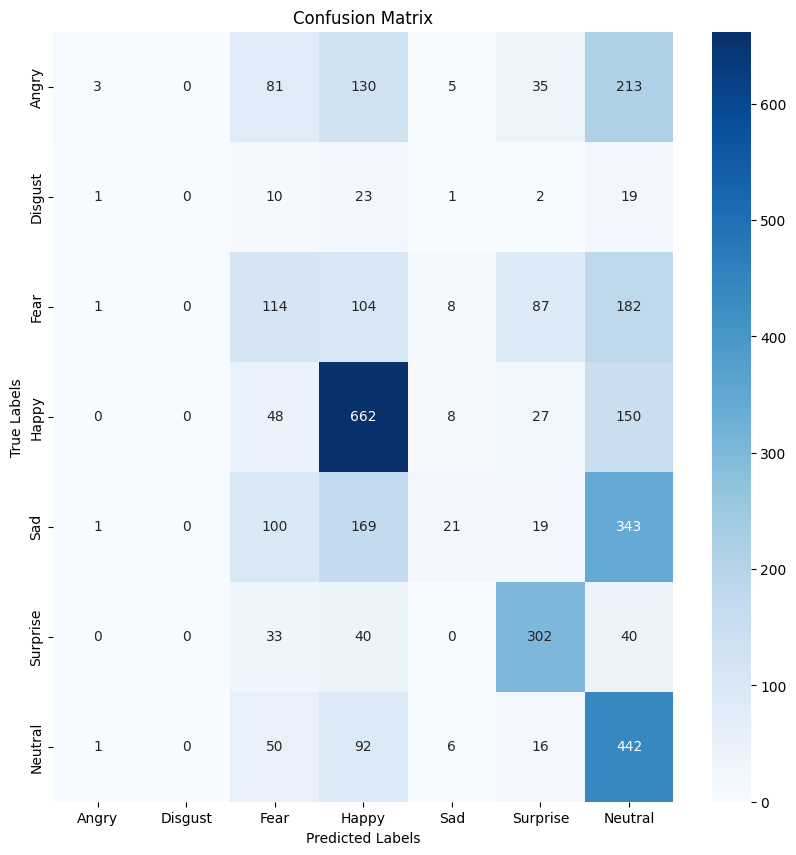

In [ ]:
"""
The get_all_preds function collects predictions from the CNN model for the entire dataset provided by a DataLoader.
It goes through all the data in batches.
For each batch it processes the images.
Both the predictions and the actual labels from the batch are stored.
As batches are processed, the predictions and labels are each added to an array, so at the end you have an array for predictions and one for labels.
These arrays are used to create a confusion matrix.
"""
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)

    return all_preds.cpu().numpy(), all_labels.cpu().numpy()

# Assuming test_generator is your DataLoader for the test set
model.eval()  # Set the model to evaluation mode
predictions, labels = get_all_preds(model, test_generator)

# Generate the confusion matrix
conf_mat = confusion_matrix(labels, predictions)
fig, ax = plt.subplots(figsize=(10, 10))  # Set appropriate size for your matrix
sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()
